# 0.0 IMPORTS

In [157]:
# Bibliotecas

import math
import numpy as np
import pandas as pd
import inflection
import seaborn as sns

from scipy import stats as ss
from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from IPython.display import Image
import datetime

from tabulate import tabulate

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Helper Functions

In [2]:
def cramer_v( x, y ):
    """Essa função calcula correlação entre duas variaveis categoricas. Para isso útilizamos a medida Cramér's V.
    Imput: x e y são as variaveis categoricas
    output: Cramér's V
    variaveis:
        cm: é a matriz de confução
        n: soma de todos os valores
        r, k: é o numero de linhas e numero de colunas
        chi2: é o resultado do teste
        chi2corr, kcorr e rcorr: é uma correção da formula
    """
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape 
    
    chi2 = ss.chi2_contingency( cm )[0]   
    
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
        
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )



def mean_absolute_percentage_error( y, yhat ):
    '''
    imput: y são os valores reais e yhat são os valores preditos
    output: o erro relativo ao valor real
    '''
    return np.mean( np.abs( ( y - yhat ) / y ) )


def ml_error( model_name, y, yhat ):
    '''
    imput: model_name é nome do modelo, y são os valores reais e yhat são os valores preditos
    output: dataframe com o nome do modelo e os erros 
    '''
    mae = mean_absolute_error( y, yhat )    # Mean absolute error regression loss.
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )    # sqrt ( Mean squared error regression loss. )
    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse }, index=[0] )


## 0.2 Loading data

In [3]:
df_sales_raw = pd.read_csv('dados/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dados/store.csv', low_memory=False)

df_raw =pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [4]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 DATA DESCRIPTION

In [5]:
df1 = df_raw.copy() 

## 1.1 Rename Columns 

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Colocando todas os nomes das colunas em minusculo e separado por underline
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase, cols_old))
df1.columns = cols_new

In [8]:
df1.head(2)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


## 1.2 Data Dimensions

In [9]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of coumns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of coumns: 18


## 1.3 Data Types

In [10]:
# first changing date type
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [11]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [12]:
# Column competition_distance  (distance in meters to the nearest competitor store)
'''
   - Estrategia da solução: Substituir o valor faltante por um valor que seja muito maior que o valor máximo, 
     dessa forma, é como de disséssemos que não há competidor próximo.
     A distância máxima é 75860.0, então substituir por um valor 200000.0 por exemplo já esta bom.
'''
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)



# Columns competition_open_since[Month/Year]  (gives the approximate year and month of the time the nearest competitor was opened)
''' 
    - Estrategia da solução: Substituir o valor faltante pelo valor da coluna 'date', pode ser que isso não funcione , mas vamos
      tentar já que essa é uma coluna muito importante.
'''
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )



# Columns Promo2Since[Year/Week]  (describes the year and calendar week when the store started participating in Promo2)
''' 
    - obs: Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
    - Estrategia da solução: Substituir o valor faltante pelo valor da coluna date
'''
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )



# Column promo_interval  (describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew.  E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store)
'''
    - Estrategia da solução: Vamos criar uma coluna 'month_map', que nos diz o mês da coluna 'date'. 
      Depois fazemos um split na coluna 'promo_interval', se a data estiver dentro da coluna 'month_map', então em uma nova coluna 'is_promo' falo que a promo2 foi ativada.
'''
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True )

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )

In [13]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [14]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( 'int64' )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( 'int64' )

# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( 'int64' )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( 'int64' )

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

In [16]:
# dados numericos
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

# dados categoricos
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

In [17]:
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
560888,829,5,4879,738,1,0,0,110.0,2,2014,0,7,2014,0
448168,724,1,5684,610,1,0,0,5900.0,5,2014,0,22,2014,0


In [18]:
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
706115,0,a,c,"Jan,Apr,Jul,Oct",Oct
110067,0,a,a,0,Apr


### 1.7.1. Numerical Atributes

In [19]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T


# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T  # range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T          # range
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T     # kurtosis


# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Atributes

In [20]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

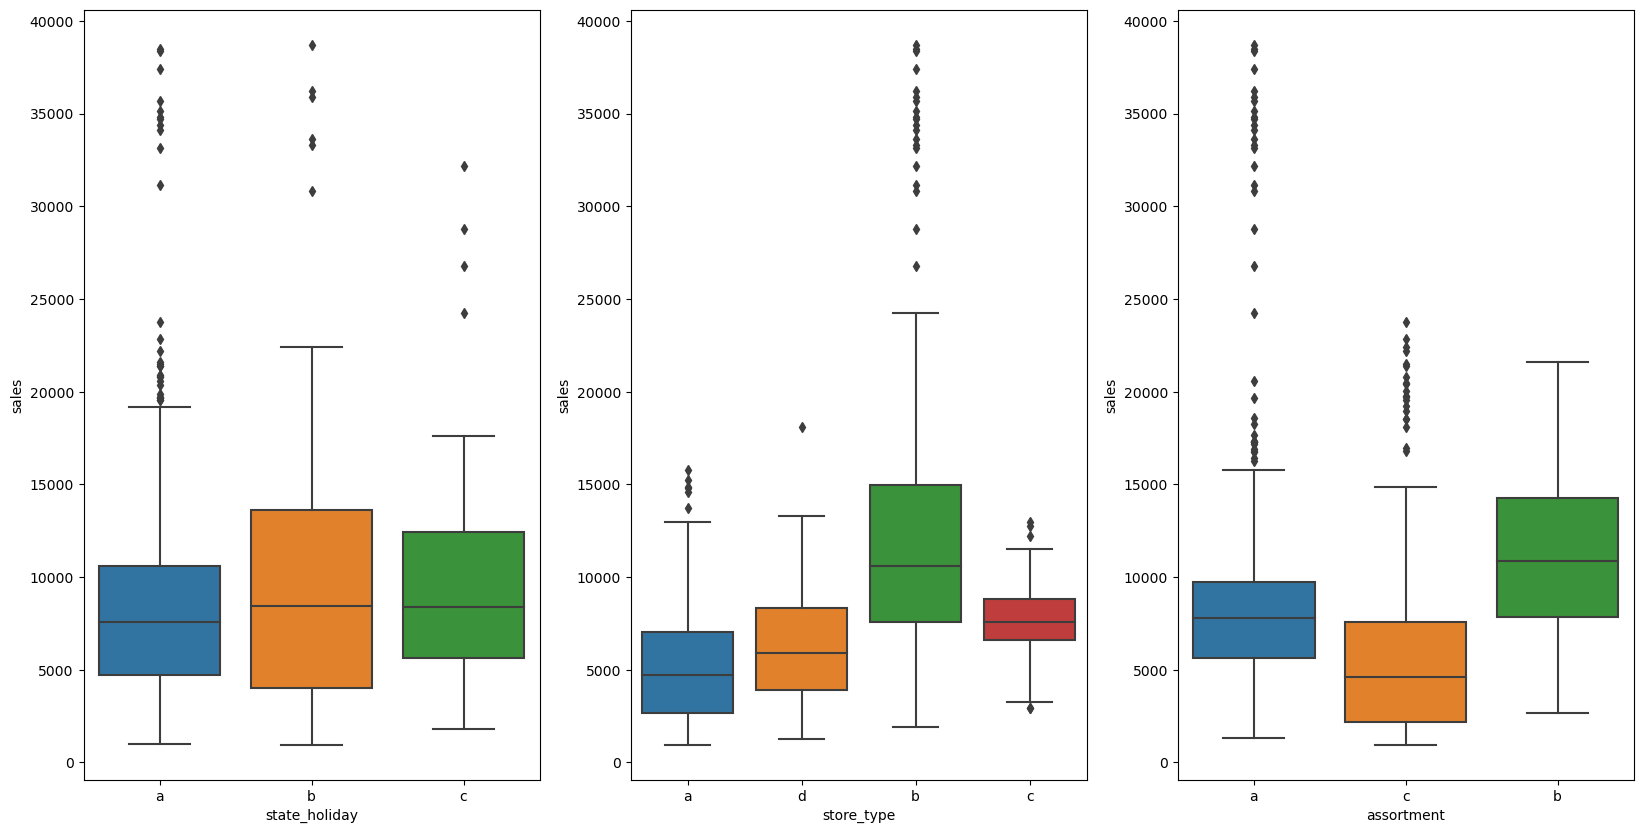

In [21]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(20,10))

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux );

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux );

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux );

# 2.0 FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipóteses

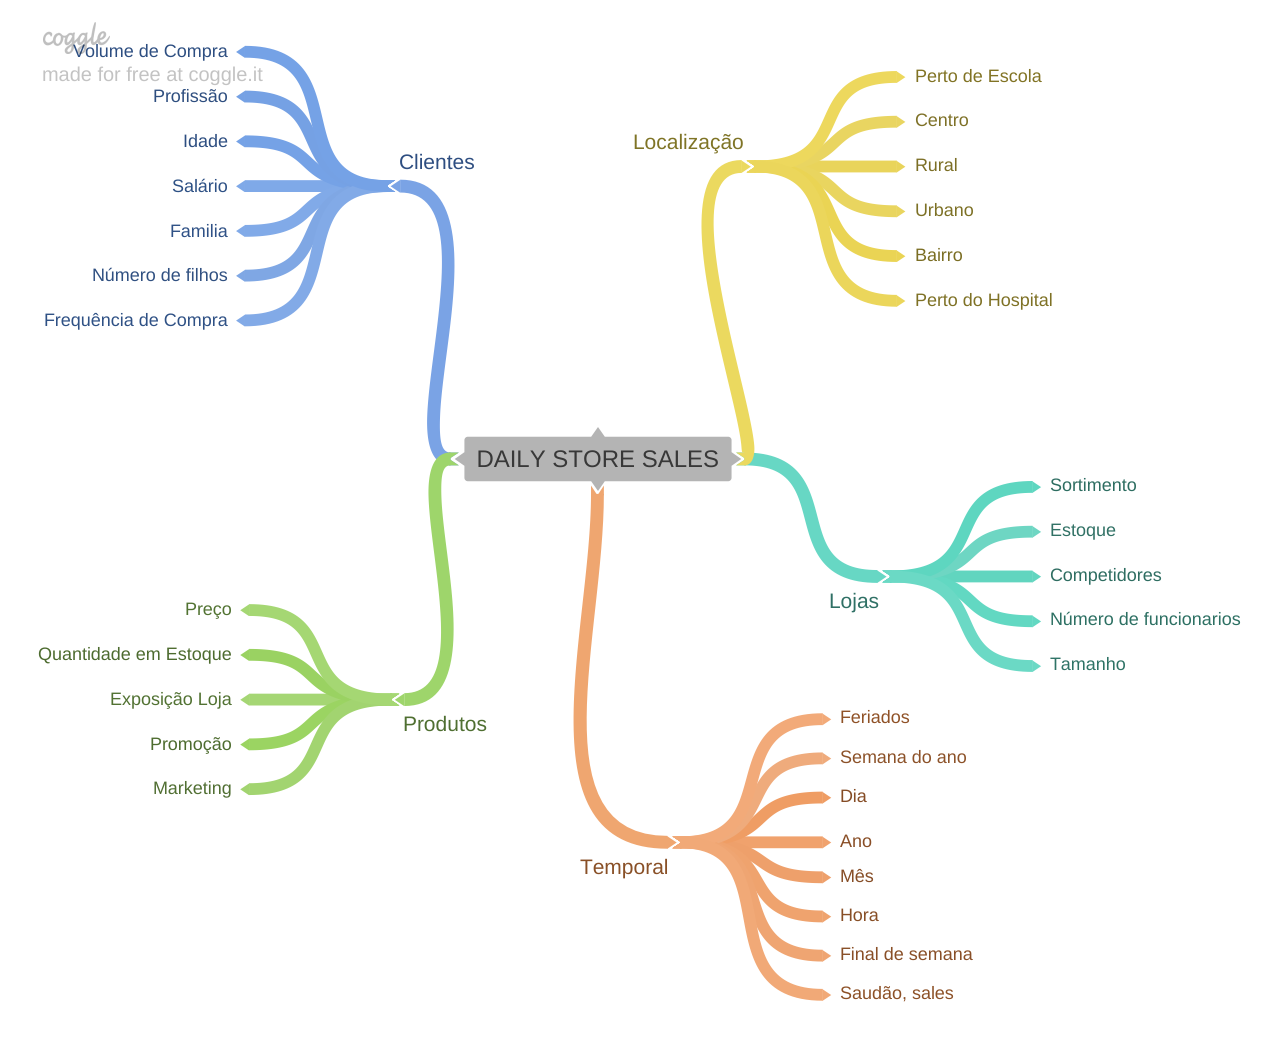

In [23]:
Image( 'img/MindMapHypothesis.png' )

## 2.2. Criação das Hipoteses

### 2.2.1. Hipoteses Loja

1. Lojas com número maior quadro de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

### 2.2.2. Hipoteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

### 2.2.3. Hipoteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

##  2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

**8.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**9.** Lojas deveriam vender mais ao longo dos anos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. Feature Engineering

In [24]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [25]:
# Criando variaveis

# year
df2['year'] = df2['date'].dt.year


# month
df2['month'] = df2['date'].dt.month


# day
df2['day'] = df2['date'].dt.day


# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear


# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )


# competition since
df2['competition_since'] = df2.apply(lambda x : datetime.datetime( year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1 ), axis=1)
df2['competition_time_month'] = ( (df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days ).astype(int)


# promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ))
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )


# assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )


# state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


C:\Users\leona\AppData\Local\Temp\ipykernel_7108\2112505755.py:16: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


# 3.0 VARIABLES FILTERING

In [26]:
df3 = df2.copy()

## 3.1. Filtragem das Linhas

In [27]:
# filtrando somente as lojas abertas 
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

In [28]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 EXPLORATORY DATA ANALYSIS (EDA)

In [29]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

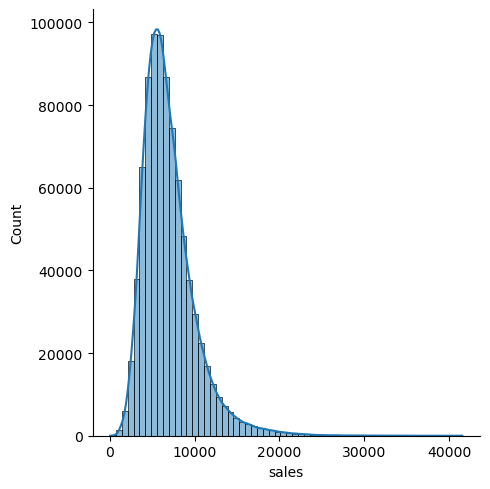

In [30]:
# Distribuição da variavel resposta "sales"
sns.displot( df4['sales'], kde=True, bins=60 );

### 4.1.2. Numerical Variable

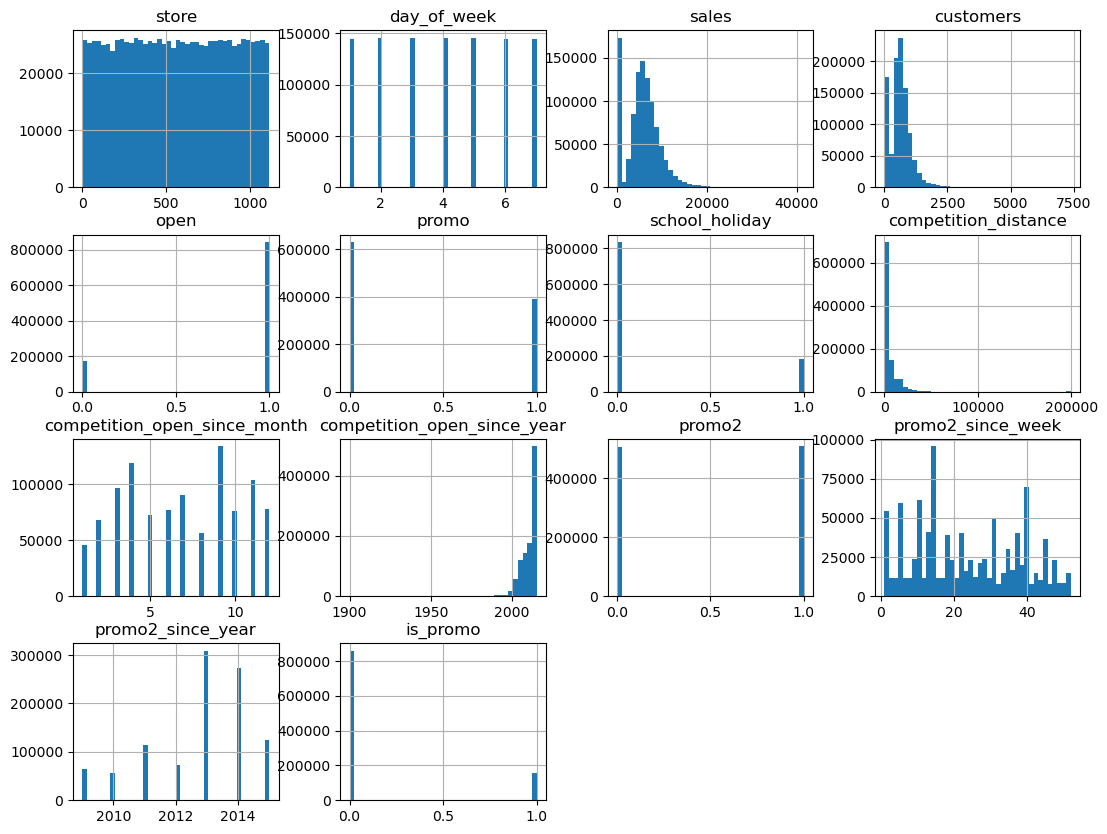

In [31]:
num_attributes.hist( bins=40,  figsize=(13,10));

### 4.1.3 Categorical Variables

In [32]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

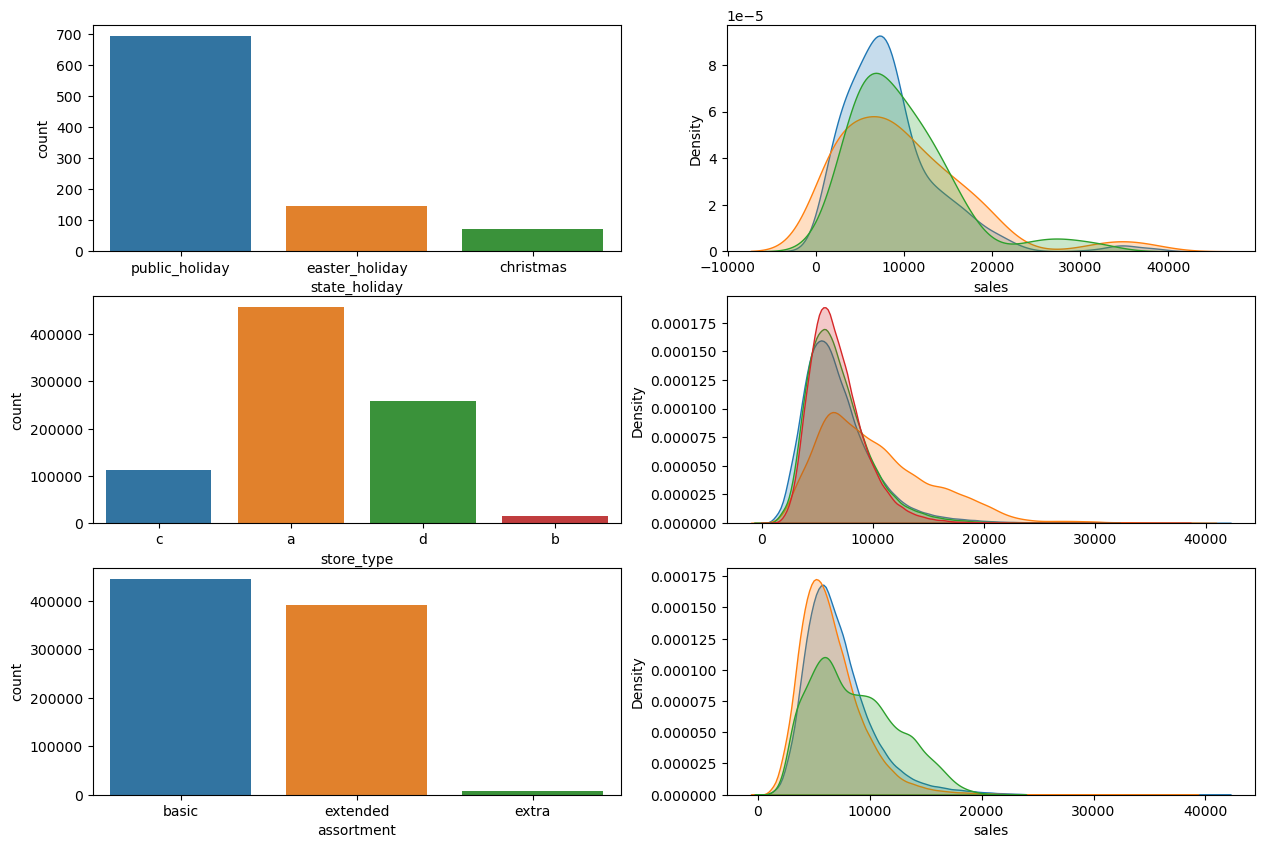

In [33]:
plt.figure(figsize=(15,10))


# state_holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x = a['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot( x = df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True)
sns.kdeplot( x = df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True )
sns.kdeplot( x = df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True )



# store_type
plt.subplot( 3, 2, 3 )
sns.countplot( x = df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', fill=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', fill=True )



# assortment
plt.subplot( 3, 2, 5 )
sns.countplot( x = df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', fill=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', fill=True )

## 4.2. Analise Bivariada

### H1. Lojas com maior sortimentos deveriam vender mais.

**FALSA** Lojas com MAIOR SORTIMENTO vendem MENOS.

<Axes: xlabel='year_week'>

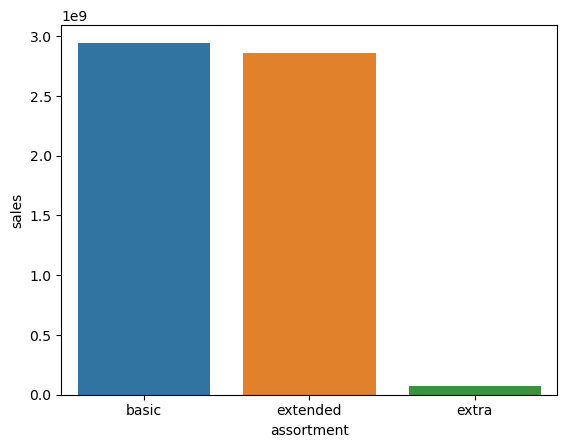

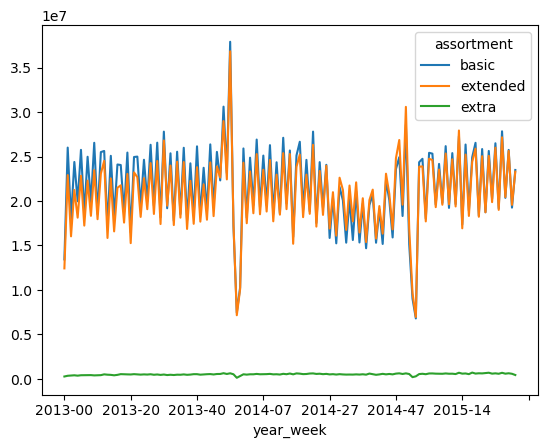

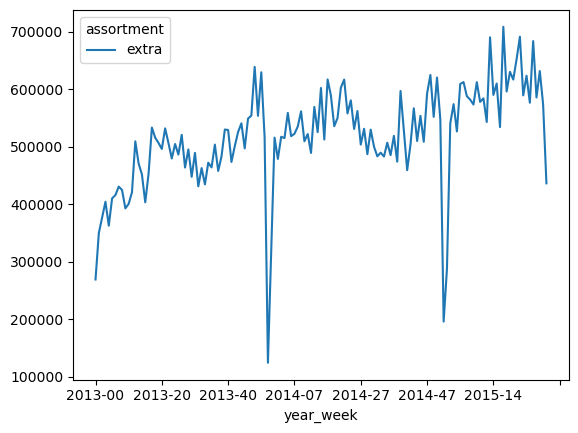

In [34]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).sum().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 );

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week','assortment'] ).sum().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

**FALSA** Lojas com COMPETIDORES MAIS PROXIMOS vendem MAIS.

C:\Users\leona\AppData\Local\Temp\ipykernel_7108\664752268.py:21: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap( aux1.corr( method='pearson' ), annot=True )


<Axes: >

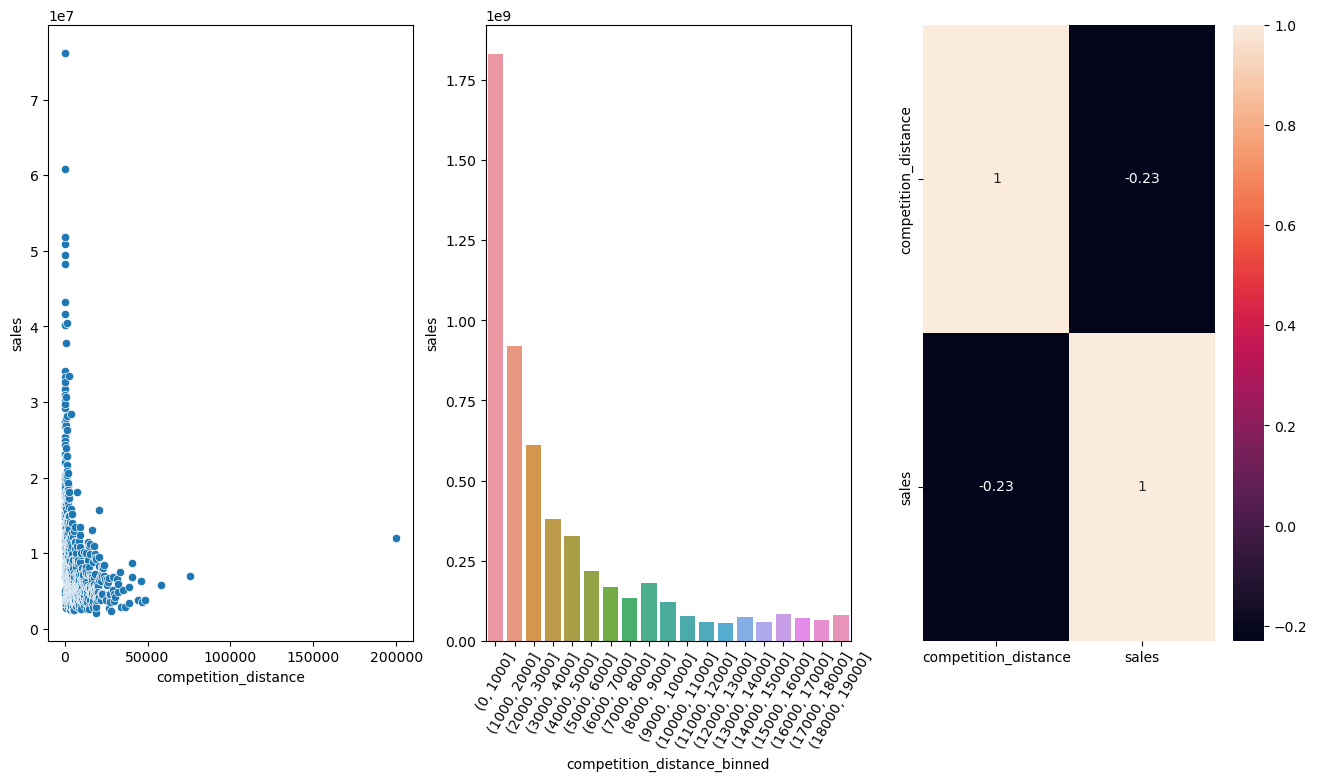

In [35]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).sum().reset_index()

bins = list (np.arange(0, 20000, 1000))

aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).sum().reset_index()



plt.figure(figsize=(16,8))


plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2)
plt.xticks( rotation=60 )

plt.subplot(1, 3, 3)
sns.heatmap( aux1.corr( method='pearson' ), annot=True )


### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSE** Lojas com COMPETIDORES À MAIS TEMPO vendem MENOS.

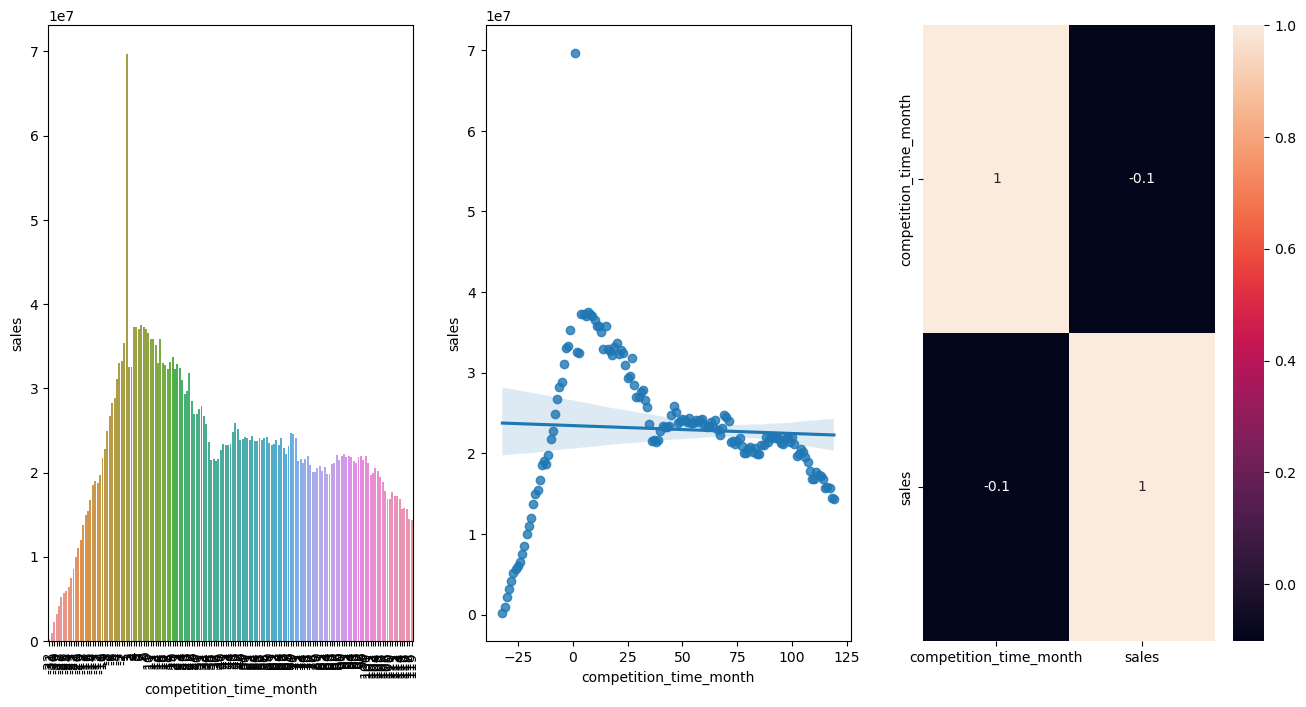

In [36]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[( aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0 )]


plt.figure(figsize=(16, 8))

plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promocoes ativas por mais tempo vendem menos, depois de um certo periodo
de promocao

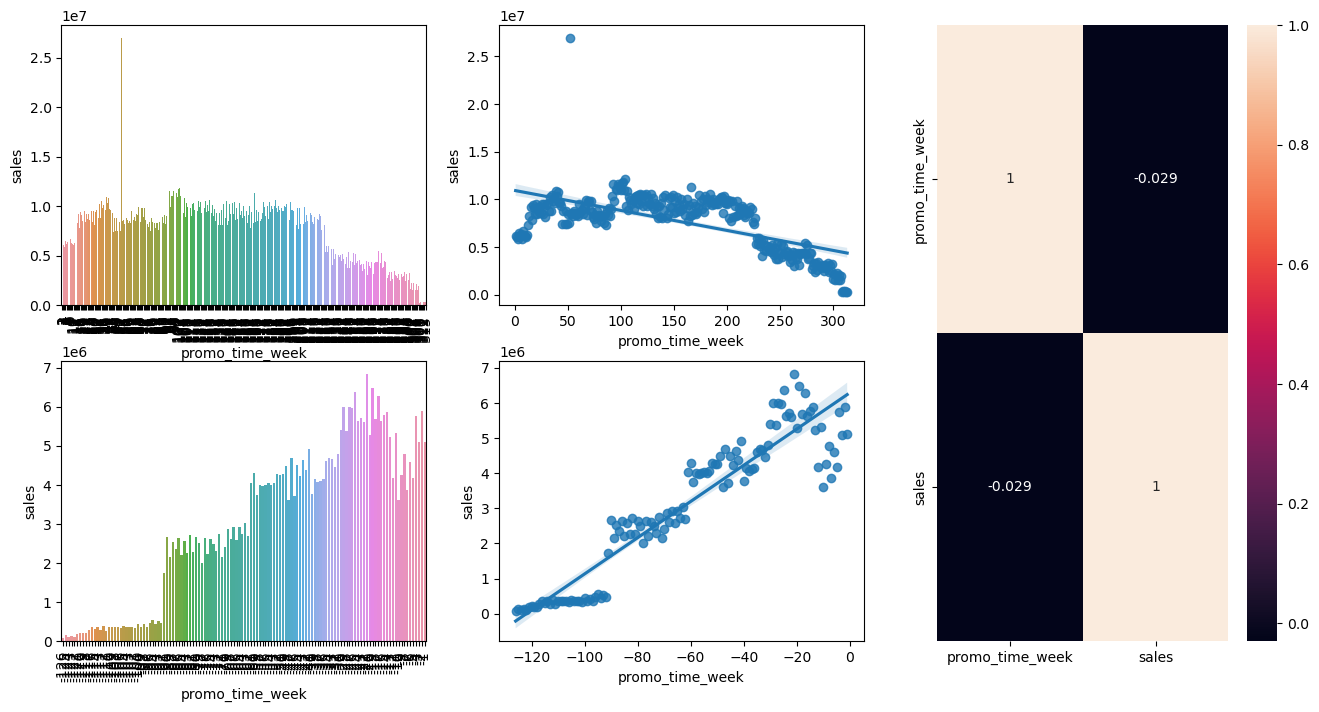

In [37]:
aux1 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week').sum().reset_index()


#grid = GridSpec( 2, 3 )

fig = plt.figure(figsize=(16, 8))
grid = fig.add_gridspec( 2, 3 )

plt.subplot( grid[0,0] )
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido

sns.barplot( x='promo_time_week', y='sales', data=aux2 );
plt.xticks( rotation=90 );

plt.subplot( grid[0,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 );

plt.subplot( grid[1,0] )
aux3 = aux1[aux1['promo_time_week'] < 0] # promo regular
sns.barplot( x='promo_time_week', y='sales', data=aux3 );
plt.xticks( rotation=90 );

plt.subplot( grid[1,1] )
sns.regplot( x='promo_time_week', y='sales', data=aux3 );

plt.subplot( grid[:,2] )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### <s> H5. Lojas com mais dias de promoção deveriam vender mais. <s/>


### H7. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promocoes consecutivas vendem menos

In [38]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


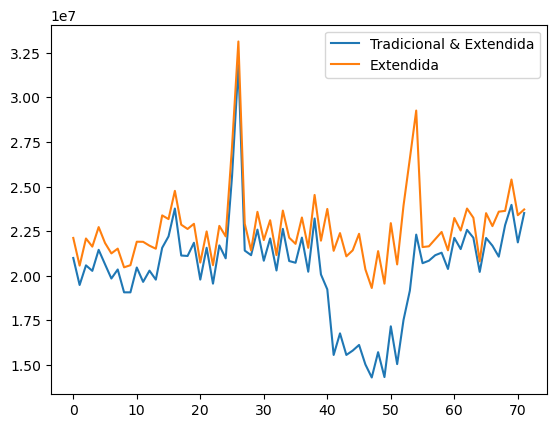

In [39]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional & Extendida', 'Extendida']);

### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado do Natal vendem menos.

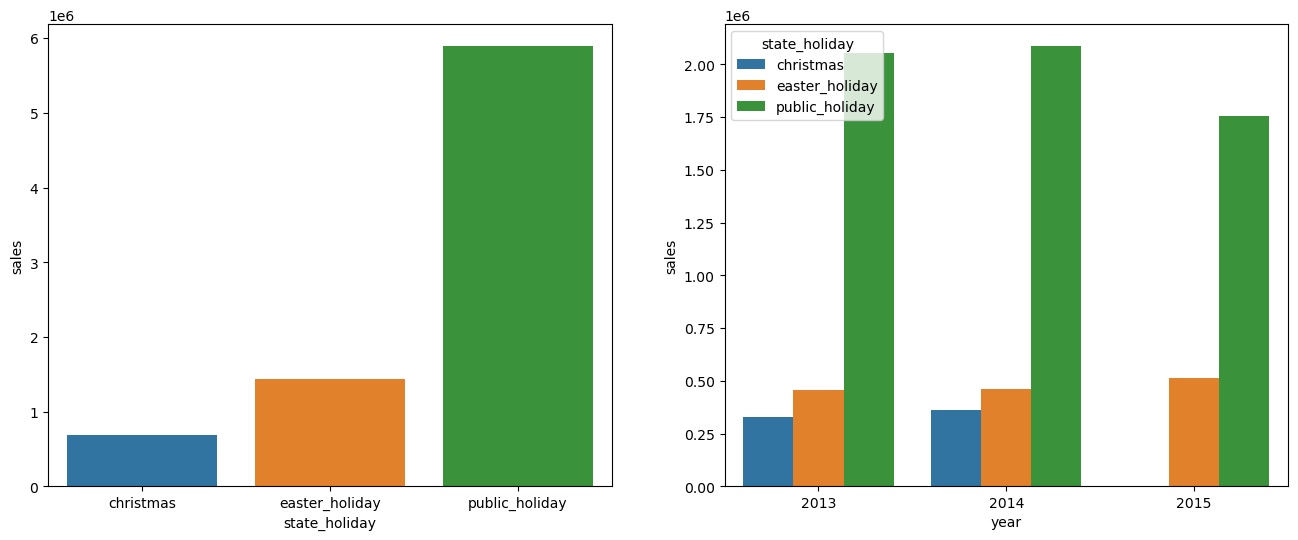

In [40]:
aux = df4[df4['state_holiday'] != 'regular_day']

fig = plt.figure(figsize = (16, 6))
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()
sns.barplot( x='state_holiday', y='sales', data=aux1 );

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### H9. Lojas deveriam vender mais ao longo dos anos.
**FALSA** Lojas vendem menos ao longo dos anos

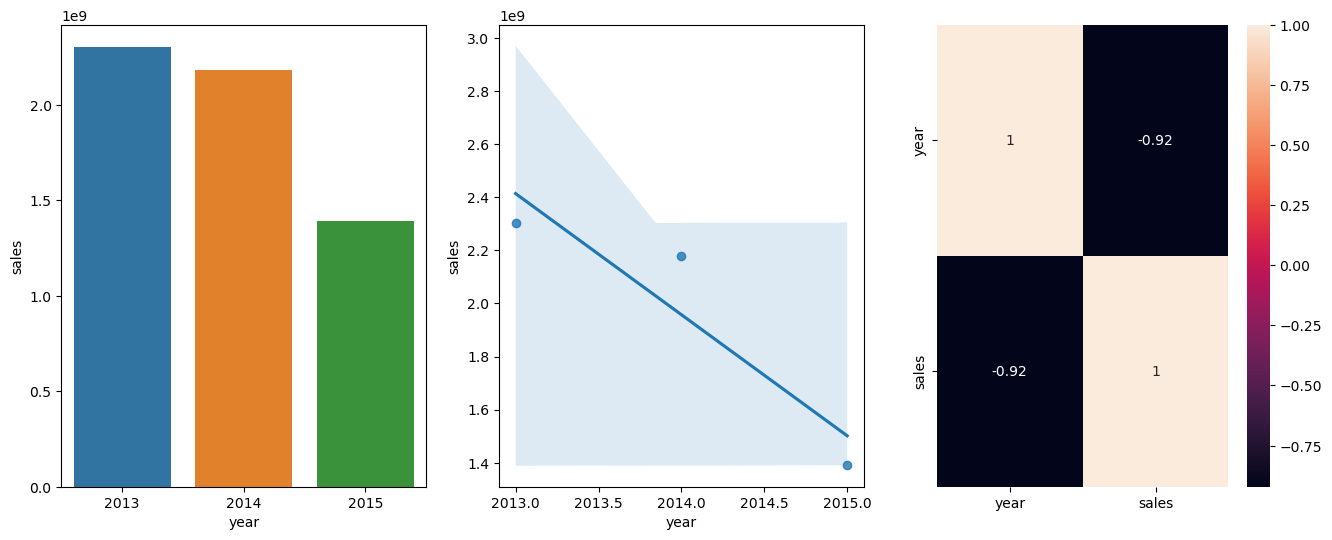

In [41]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()

fig = plt.figure(figsize=(16, 6))

plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H10. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA** Lojas vendem menos no segundo semestre do ano

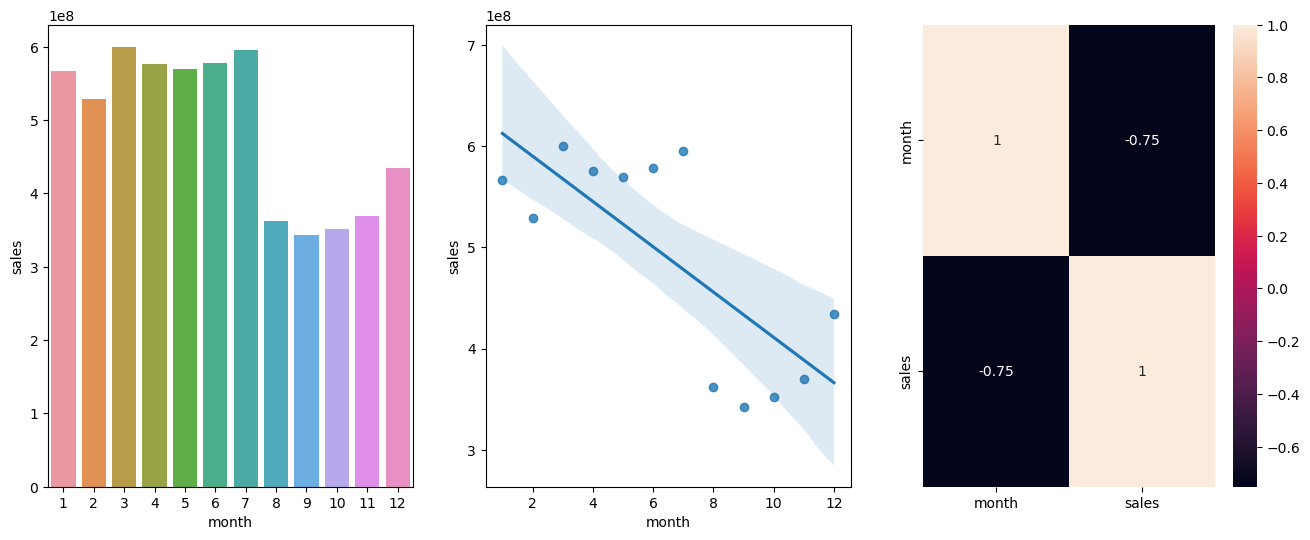

In [42]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()

fig = plt.figure(figsize=(16, 6))

plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mes.

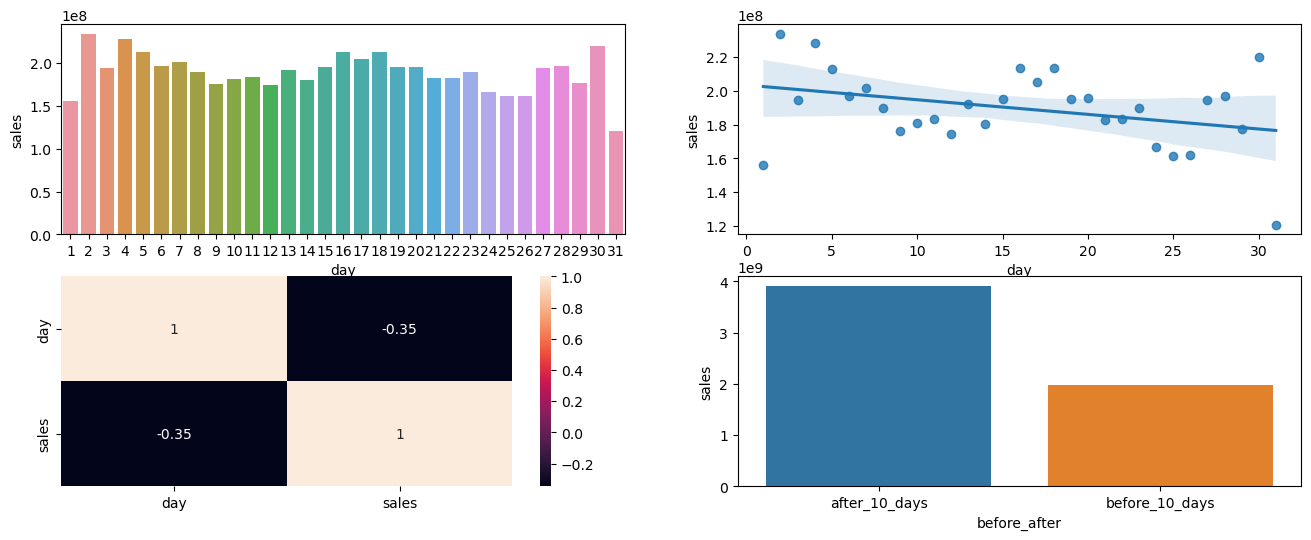

In [43]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()


fig = plt.figure(figsize = (16, 6)) 

plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );

plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );
aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

In [44]:
df4.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [45]:
aux['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')

63559      before_10_days
63560      before_10_days
63609      before_10_days
63611      before_10_days
63614      before_10_days
                ...      
1016776    before_10_days
1016827    before_10_days
1016863    before_10_days
1017042    before_10_days
1017190    before_10_days
Name: day, Length: 910, dtype: object

### H12. Lojas deveriam vender menos aos finais de semana.
**VERDADEIRA** Lojas vendem menos nos final de semana

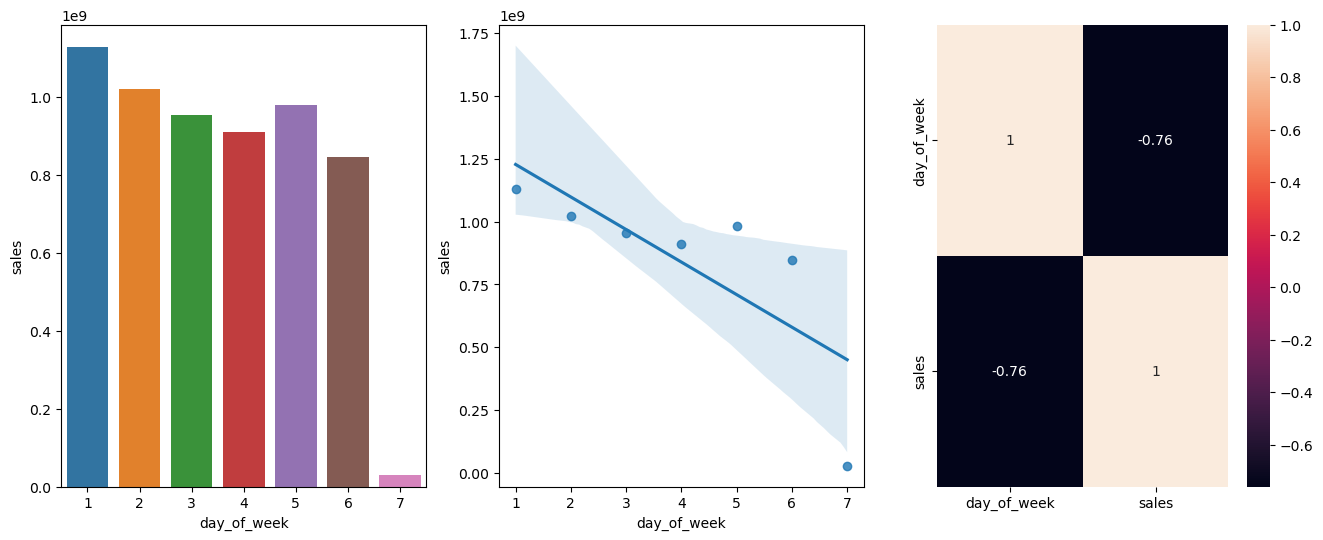

In [46]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()

fig =plt.figure(figsize = (16, 6))
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );

plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

### H13. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas vendem menos durante os feriadso escolares, exceto nos meses de Julho e
Agosto.

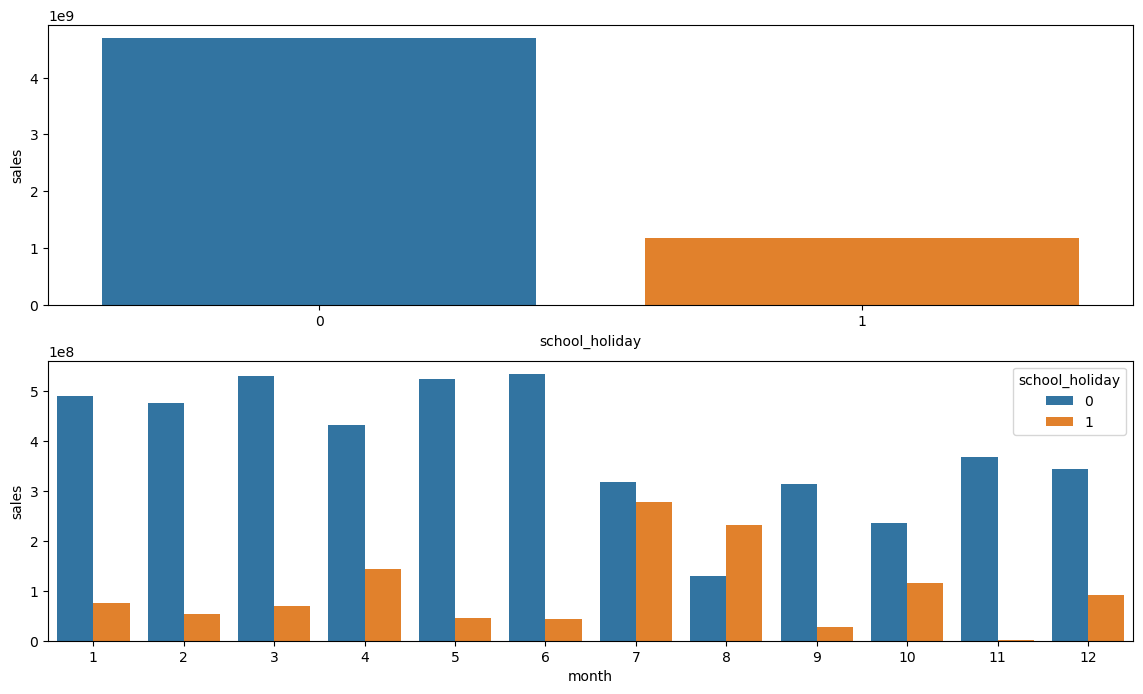

In [47]:
fig = plt.figure(figsize = (14, 8)) 

aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );


aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );

4.2.1. Resumo das Hipoteses

In [48]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],

['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

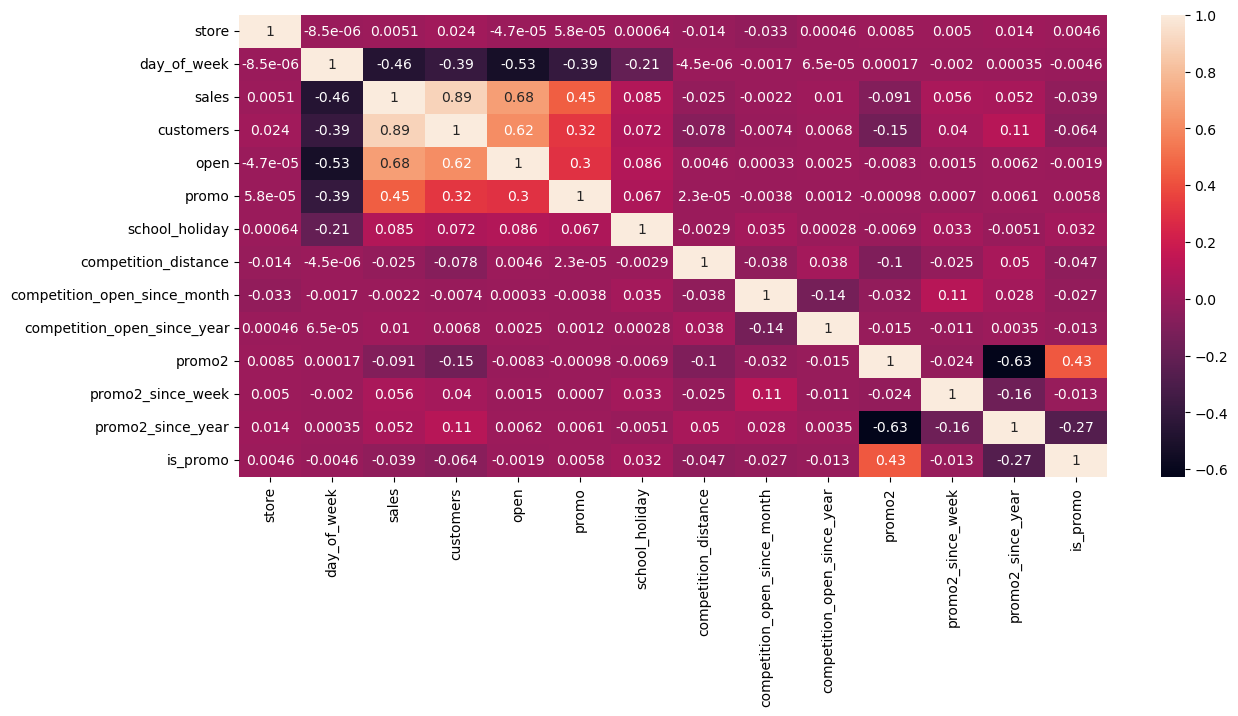

In [49]:
correlation = num_attributes.corr( method='pearson' )

fig = plt.figure(figsize = (14, 6)) 
sns.heatmap( correlation, annot=True );

### 4.3.2. Categorical Attributes

Para ver a correlação entre as variaveis categoricas vamos usar o [Cramér's V](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V)

<Axes: >

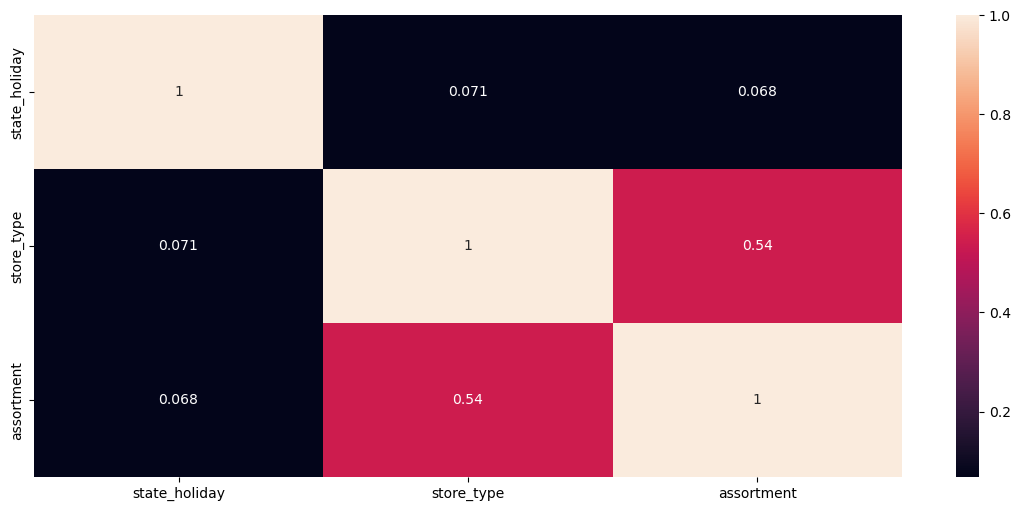

In [50]:
# only categorical data
a = df4.select_dtypes( include='object' )

# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )

# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )

fig = plt.figure(figsize = (14, 6)) 
sns.heatmap( d, annot=True )

# 5.0 DATA PREPARATION


In [61]:
df5 = df4.copy()

## 5.1. Normalizacao

In [52]:
# Devido a análise feita nos gráficos da análise univariada, não se percebeu nenhuma distribuiçao normal,
# dessa forma, essa etapa não será necessaria.

## 5.2. Rescaling

In [53]:
rs = RobustScaler()   # Usar quando os outliers são bem fortes
mms = MinMaxScaler()  # Usar quando os outliers não são tão relevantes

# competition distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values )

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

# year
df5['year'] = mms.fit_transform( df5[['year']].values )

In [54]:
df5.head(4)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,...,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,...,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,...,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,...,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016


## 5.3 Transformação

### 5.3.1. Encoding

In [55]:
# state_holiday - One Hot Encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] )

# store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform( df5['store_type'] )


# assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map( assortment_dict )

In [56]:
df5.head(4)

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1


### 5.3.2. Response Variable Transformation

In [57]:
#Logarithm Transformation - Trazer a distribuição da variavel resposta o mais próximo de uma distribuição normal
df5['sales'] = np.log1p( df5['sales'] )

### 5.3.3. Nature Transformation

In [58]:
# Natureza ciclica
# obs: ciclo trigonometrico de raio 1 tem comprimento igual a 2*pi


# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2. *np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2. *np.pi/7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2. * np.pi/12 )) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2. * np.pi/12 )) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2. * np.pi/52 ) ) )

# 6.0 FEATURE SELECTION

In [59]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [62]:
# primeiro deletamos as variaveis que delas originaram outras variaveis 
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week' ]
df6 = df6.drop( cols_drop, axis=1 )

In [130]:
'''
OBS: 
Subtraindo 6 semanas da última data:    
    df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)
    Resultado: Timestamp('2015-06-19 00:00:00')
'''

# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']


print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [133]:
## training and test dataset for Boruta
#X_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
#y_train_n = y_train.values.ravel()
#
## define RandomForestRegressor
#rf = RandomForestRegressor( n_jobs=-1 )
#
## define Boruta  
#boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit(X_train_n, y_train_n )



### 6.2.1. Best Features from Boruta

In [ ]:
#cols_selected = boruta.support_.tolist()
#
## best features
#X_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()
#
## not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d( X_train_fs.columns,cols_selected_boruta ) )

## 6.3. Manual Feature Selection

In [139]:
# OBS: o boruta demora muito para rodar, cerca de 4 hrs, por isso aqui só coloco o resultado.

cols_selected_boruta = [

'store',
'promo',
'store_type',
'assortment',
'competition_distance',
'competition_open_since_month',
'competition_open_since_year',
'promo2',
'promo2_since_week',
'promo2_since_year',
'competition_time_month',
'promo_time_week',
'day_of_week_sin',
'day_of_week_cos',
'month_sin',
'month_cos',
'day_sin',
'day_cos',
'week_of_year_sin',
'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [142]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0 MACHINE LEARNING MODELLING

In [146]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

## 7.1. Average Model

In [158]:
def mean_absolute_percentage_error( y, yhat ):
    '''
    imput: y são os valores reais e yhat são os valores preditos
    output: o erro relativo ao valor real
    '''
    return np.mean( np.abs( ( y - yhat ) / y ) )

def mean_percentage_error( y, yhat ):
    return np.mean( ( y - yhat ) / y )



def ml_error( model_name, y, yhat ):
    '''
    imput: model_name é nome do modelo, y são os valores reais e yhat são os valores preditos
    output: dataframe com o nome do modelo e os erros 
    '''
    mae = mean_absolute_error( y, yhat )    # Mean absolute error regression loss.
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )    # sqrt ( Mean squared error regression loss. )
    return pd.DataFrame( { 'Model Name': model_name,
                            'MAE': mae,
                            'MAPE': mape,
                            'RMSE': rmse }, index=[0] )


In [159]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression Model

In [160]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr ) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


## 7.3. Linear Regression Regularized Model - Lasso

In [162]:
# model
lrr = Lasso( alpha=0.001 ).fit( x_train, y_train )    # quanto menor alpha, melhor fica !

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1869.571858,0.288111,2694.005137


---

### Conclusão até agora:

O erro de regressão linear é muito maior que o erro de média, ou seja:
 - O modelo de média é melhor que uma regressão linear.
 - Os dados tem um comportamento não linear.


 #### Próximo passo:
 Testar modelos não lineares.